In [1]:
# загрузка библиотек
import pandas as pd
import collections
from datetime import datetime
import re
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# подгружаем данные для работы
data = pd.read_csv('main_task.csv')
data_origin = data.copy() # будет необходим для визуальной оценки изначальных параметров

# 1. Обработка данных

## 1.1. Обработка NAN

In [4]:
# отмечаем есть ли пропуски в столбце Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

# заполняем пропуски
data['Number of Reviews'].fillna(0, inplace=True)
data['Reviews'].fillna('[[][]]')

0        [['Good food at your doorstep', 'A good hotel ...
1        [['Unique cuisine', 'Delicious Nepalese food']...
2        [['Catch up with friends', 'Not exceptional'],...
3                                                 [[], []]
4        [['Best place to try a Bavarian food', 'Nice b...
                               ...                        
39995    [['The real Italian experience!', 'Wonderful f...
39996    [['Parisian atmosphere', 'Bit pricey but inter...
39997    [['Good by swedish standards', 'A hidden jewel...
39998    [['Underground restaurant', 'Oldest Restaurant...
39999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 40000, dtype: object

# 1.2. Обработка признаков

In [5]:
data.nunique(dropna=False)

Restaurant_id              11909
City                          31
Cuisine Style               9008
Ranking                    11936
Rating                         9
Price Range                    4
Number of Reviews           1460
Reviews                    33516
URL_TA                     39980
ID_TA                      39980
Number_of_Reviews_isNAN        2
dtype: int64

In [6]:
# функция для создания отношение ревью по ресторану в городе к общему кол-ву ревью по городу
def create_column_ratio_reviews(df_input):
    df_output = df_input.copy()
    cities_avg_rev = df_output.groupby('City')['Number of Reviews'].mean()
    
    def get_ratio(num_rev, avg_value):
        return num_rev/avg_value
    
    df_output['Ratio_Reviews'] =  df_output.apply(lambda x: get_ratio(x['Number of Reviews'], cities_avg_rev[x['City']]), axis = 1)
    return df_output

In [7]:
data=create_column_ratio_reviews(data)

In [8]:
# разбиваем по признаку в каком городе какой ресторан находится
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

In [9]:
# функция для преобразования столбца
def update_price_range(df_input):
    df_output = df_input.copy()
    price_range_type = {
        '$': 1,
        '$$ - $$$': 2,
        '$$$$': 3,
    }

    df_output['Price Range']=df_output['Price Range'].replace(to_replace=price_range_type)
    #fill nan value to 0
    df_output['Price Range']=df_output['Price Range'].fillna(0)
    
    return df_output

In [10]:
data = update_price_range(data)

In [11]:
# Очистка и подготовка столбца Cuisine Style для дальнейшей работы
def convert_cuisines_styles(df_input):
    df_output = df_input.copy()
    df_output['Cuisine Style']=df_output['Cuisine Style'].fillna('')
    df_output['Cuisine Style']=df_output['Cuisine Style'].apply(lambda x:x.replace('[', ''))
    df_output['Cuisine Style']=df_output['Cuisine Style'].apply(lambda x:x.replace(']', ''))
    return df_output

In [12]:
data = convert_cuisines_styles(data)

In [13]:
# преобразование столбца cuisine style в отдельные подстолбцы
def add_cuisine_style_columns(df_input):
    df_output = df_input.copy()
    unique_cus_style = set()
    for item in df_output['Cuisine Style']:
        arr= item.split(',')
        unique_cus_style.update(arr)

    unique_cus_style = [x.replace("'","").strip() for x in unique_cus_style if x!=""]
    
    #create columns in data
    for item in unique_cus_style:
        df_output[item]=0

    def set_cuisine(x, elem):
        arr = x.split(',')
        arr_conv=[item.replace("'","").strip() for item in arr if item!=""]
        if elem in arr_conv:
            return 1
        return 0

    for item in unique_cus_style:
        df_output[item]=df_output['Cuisine Style'].apply(set_cuisine, args=(item,)).astype('uint8')
    
    return df_output

In [14]:
data=add_cuisine_style_columns(data)

In [15]:
# функция проверяет есть ли в ресторане топовые кухни (берутся 4 наиболее популярные)
def get_top_cuisine_style(df_input):
    df_output = df_input.copy()
    cus_style_count = collections.Counter()
    for item in df_output['Cuisine Style']:
        arr= item.split(',')
        arr = [x.replace("'","").strip() for x in arr if x!=""]
        for elem in arr:
            cus_style_count[elem] +=1

    return cus_style_count.most_common(4)

def add_column_has_top_cuisine(df_input):
    df_output = df_input.copy()
    top_cuisines = get_top_cuisine_style(df_output)
    top_cuisines = [x[0] for x in top_cuisines]
    
    def has_top_cuisines(x, top_cuisines):
        arr = x.split(',')
        arr_conv=[item.replace("'","").strip() for item in arr if item!=""]
        return int(bool(set(arr_conv) & set(top_cuisines)))
    
    df_output['Is top cuisines'] = df_output['Cuisine Style'].apply(has_top_cuisines, args=(top_cuisines,)).astype('uint8')
    return df_output

In [16]:
data = add_column_has_top_cuisine(data)

In [17]:
# функция создает столбец с количеством кухонь в ресторане
def create_column_number_of_cuisines(df_input):
    df_output = df_input.copy()
    
    def get_number_of_cuisines(x):
        arr = x.split(',')
        return len(arr)
    df_output['Cuisines_Num']=df_output['Cuisine Style'].apply(get_number_of_cuisines).astype('uint8')
    return df_output

In [18]:
data = create_column_number_of_cuisines(data)

In [19]:
# разница во времени между 1-ым и последним ревью
def create_column_time_dif(df_input):
    df_output = df_input.copy()
    def get_diff(x):
        
        arr = re.findall( '\d{2}\/\d{2}\/\d{4}', str(x), re.I|re.M)
        arrd=[datetime.strptime(x, '%m/%d/%Y') for x in arr]
        if(len(arrd)>1):
            return (max(arrd)-min(arrd)).days
        return 0
    df_output['Time_Review_Diff']=df_output['Reviews'].apply(get_diff)
    return df_output

In [20]:
data = create_column_time_dif(data)

In [21]:
data.head()

,Restaurant_id,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Number_of_Reviews_isNAN,...,Danish,Gluten Free Options,Mediterranean,Scandinavian,Xinjiang,Polynesian,Burmese,Is top cuisines,Cuisines_Num,Time_Review_Diff
0,id_5569,"'European', 'French', 'International'",5570.0,3.5,2.0,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,0,...,0,0,0,0,0,0,0,1,3,41
1,id_1535,,1537.0,4.0,0.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,0,...,0,0,0,0,0,0,0,0,1,382
2,id_352,"'Japanese', 'Sushi', 'Asian', 'Grill', 'Vegeta...",353.0,4.5,3.0,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,0,...,0,1,0,0,0,0,0,1,7,2
3,id_3456,,3458.0,5.0,0.0,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,0,...,0,0,0,0,0,0,0,0,1,0
4,id_615,"'German', 'Central European', 'Vegetarian Frie...",621.0,4.0,2.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,0,...,0,0,0,0,0,0,0,1,3,272


# 2. Проверка получившихся признаков

# 2.1. Проверка корреляции

Из проверка корреляции были исключены столбцы с городами и видами кухонь, в силу того, что их наличие затрудняло оценку остальных признаков.

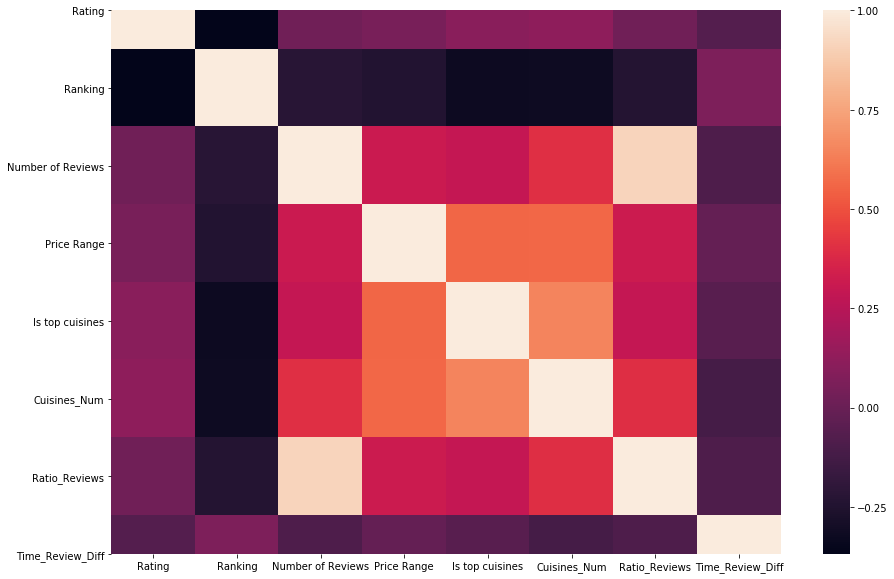

In [22]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[[ 'Rating', 'Ranking', 'Number of Reviews', 'Price Range', 'Is top cuisines', 'Cuisines_Num', 'Ratio_Reviews', 'Time_Review_Diff']].corr(),)

In [23]:
corr = data[[ 'Rating', 'Ranking', 'Number of Reviews', 'Price Range', 'Is top cuisines', 'Cuisines_Num', 'Ratio_Reviews', 'Time_Review_Diff']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Rating,Ranking,Number of Reviews,Price Range,Is top cuisines,Cuisines_Num,Ratio_Reviews,Time_Review_Diff
Rating,1,-0.368371,0.0269242,0.0516431,0.102897,0.120059,0.0263242,-0.0659896
Ranking,-0.368371,1,-0.222072,-0.243553,-0.3224,-0.32025,-0.237265,0.0656608
Number of Reviews,0.0269242,-0.222072,1,0.312668,0.291775,0.405641,0.916132,-0.0865861
Price Range,0.0516431,-0.243553,0.312668,1,0.55899,0.565227,0.319591,-0.0114082
Is top cuisines,0.102897,-0.3224,0.291775,0.55899,1,0.647474,0.289492,-0.0555025
Cuisines_Num,0.120059,-0.32025,0.405641,0.565227,0.647474,1,0.399976,-0.117791
Ratio_Reviews,0.0263242,-0.237265,0.916132,0.319591,0.289492,0.399976,1,-0.0876064
Time_Review_Diff,-0.0659896,0.0656608,-0.0865861,-0.0114082,-0.0555025,-0.117791,-0.0876064,1


# 3. Очистка признаков, после анализа корреляции

In [24]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [25]:
data

,Ranking,Rating,Price Range,Number of Reviews,Number_of_Reviews_isNAN,Ratio_Reviews,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Danish,Gluten Free Options,Mediterranean,Scandinavian,Xinjiang,Polynesian,Burmese,Is top cuisines,Cuisines_Num,Time_Review_Diff
0,5570.0,3.5,2.0,194.0,0,1.692098,0,0,0,0,...,0,0,0,0,0,0,0,1,3,41
1,1537.0,4.0,0.0,10.0,0,0.138807,0,0,0,0,...,0,0,0,0,0,0,0,0,1,382
2,353.0,4.5,3.0,688.0,0,5.308416,0,0,0,0,...,0,1,0,0,0,0,0,1,7,2
3,3458.0,5.0,0.0,3.0,0,0.049813,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,621.0,4.0,2.0,84.0,0,1.114575,0,0,0,0,...,0,0,0,0,0,0,0,1,3,272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,500.0,4.5,2.0,79.0,0,0.477848,0,0,0,0,...,0,1,0,0,0,0,0,1,4,34
39996,6341.0,3.5,2.0,542.0,0,4.727406,0,0,0,0,...,0,0,0,0,0,0,0,1,5,9
39997,1652.0,4.5,0.0,4.0,0,0.055523,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3127
39998,641.0,4.0,2.0,70.0,0,1.206811,0,0,0,0,...,0,0,0,0,0,0,0,1,5,23


In [26]:
# удаляем колонку Ratio_Reviews, так как она имеет высокую корреляцию с колонкой Number of Reviews
data.drop('Ratio_Reviews', axis = 1, inplace=True)

In [27]:
data.head()

,Ranking,Rating,Price Range,Number of Reviews,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Danish,Gluten Free Options,Mediterranean,Scandinavian,Xinjiang,Polynesian,Burmese,Is top cuisines,Cuisines_Num,Time_Review_Diff
0,5570.0,3.5,2.0,194.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,41
1,1537.0,4.0,0.0,10.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,382
2,353.0,4.5,3.0,688.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,7,2
3,3458.0,5.0,0.0,3.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,621.0,4.0,2.0,84.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,272


In [28]:
# проверим корреляцию ряда столбцов снова
corr = data[[ 'Rating', 'Ranking', 'Number of Reviews', 'Price Range', 'Is top cuisines', 'Cuisines_Num', 'Time_Review_Diff']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Rating,Ranking,Number of Reviews,Price Range,Is top cuisines,Cuisines_Num,Time_Review_Diff
Rating,1,-0.368371,0.0269242,0.0516431,0.102897,0.120059,-0.0659896
Ranking,-0.368371,1,-0.222072,-0.243553,-0.3224,-0.32025,0.0656608
Number of Reviews,0.0269242,-0.222072,1,0.312668,0.291775,0.405641,-0.0865861
Price Range,0.0516431,-0.243553,0.312668,1,0.55899,0.565227,-0.0114082
Is top cuisines,0.102897,-0.3224,0.291775,0.55899,1,0.647474,-0.0555025
Cuisines_Num,0.120059,-0.32025,0.405641,0.565227,0.647474,1,-0.117791
Time_Review_Diff,-0.0659896,0.0656608,-0.0865861,-0.0114082,-0.0555025,-0.117791,1


# 4. Выборка тестовых данных 

In [29]:
X = data.drop(['Rating'], axis = 1)
y = data['Rating']
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 5. Обучаем модель

In [30]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [31]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21344449999999998
